In [1]:
#Libraries Needed
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook

In [2]:
import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection']


In [3]:
print(os.listdir("../input/aptos2019-blindness-detection"))

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']


In [4]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [5]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [6]:
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [45]:
test_transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


In [8]:
test_csv['diagnosis'] = -1

In [9]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [10]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [11]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [12]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [15]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [16]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
test_dir = "../input/aptos2019-blindness-detection/test_images/"

In [19]:
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in test_loader:
        i += 1
        if i % 10 == 0:
            print(f'{i} pass step')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        p_labels.append(preds)
    # getting ids of file images  

10 pass step
20 pass step
30 pass step


In [20]:
p_labels

[tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4,

In [21]:
pred_labels = []
for l in p_labels:
    for l1 in l:
        pred_labels.append(l1.item())

In [22]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [23]:
sample_sub.diagnosis = pred_labels
sample_sub.head


<bound method NDFrame.head of            id_code  diagnosis
0     0005cfc8afb6          4
1     003f0afdcd15          4
2     006efc72b638          4
3     00836aaacf06          4
4     009245722fa4          4
...            ...        ...
1923  ff2fd94448de          4
1924  ff4c945d9b17          4
1925  ff64897ac0d8          4
1926  ffa73465b705          4
1927  ffdc2152d455          4

[1928 rows x 2 columns]>

In [24]:
sample_sub.to_csv('submission.csv', index=False)

In [58]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

def test_with_single_image(model, file, transform, classes):
    # Open the image and convert it to RGB
    img = Image.open(file).convert('RGB')

    # Apply the transformation to convert it to a tensor
    img_tensor = transform(img)

    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        model.eval()
        img_tensor = img_tensor.to(device)

        # Perform inference with the model
        output = model(img_tensor)

    # Get the predicted class index
    _, predicted = torch.max(output, 1)

    # Map the predicted index to the class label
    predicted_class = classes[predicted.item()]

    # Display the image with the predicted class label
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class


In [59]:
import os
import random

test_dir = "../input/aptos2019-blindness-detection"
# List all subdirectories in test_dir
folders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

# Select a random folder
random_folder = random.choice(folders)
folder_path = os.path.join(test_dir, random_folder)
print("Folder path:", folder_path)

# List all files in the selected folder
files = os.listdir(folder_path)

# Select a random file
random_file = random.choice(files)
file_path = os.path.join(folder_path, random_file)
print("File path:", file_path)


Folder path: ../input/aptos2019-blindness-detection/test_images
File path: ../input/aptos2019-blindness-detection/test_images/cf95d13f210a.png


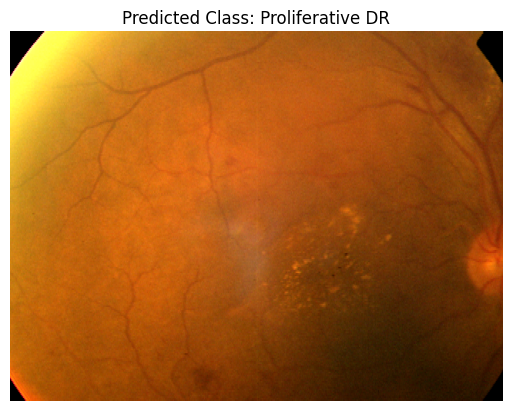

Predicted class: Proliferative DR


In [60]:
# Call the test_with_single_image function
predicted_class = test_with_single_image(model, name, test_transforms, classes)

# Print the predicted class
print("Predicted class:", predicted_class)

